# Creating surface forcing

In [1]:
from roms_tools import Grid

As always, the first step is to create our grid. Note that it is important to use the same grid throughout all the steps (i.e., creating tidal forcing, surface forcing, initial conditions, etc.) to set up a consistent ROMS simulation. Here we use the following grid.

In [2]:
grid = Grid(
    nx=100, ny=100, size_x=2000, size_y=2400, center_lon=-18, center_lat=33, rot=-20
)

Next, we specify the temporal range that we want to make the surface forcing for.

In [3]:
from datetime import datetime

In [4]:
start_time = datetime(2012, 1, 15)
end_time = datetime(2012, 2, 5)

For the time being, `ROMS-Tools` can only interpolate surface forcing fields from ERA5. The user is expected to have downloaded the ERA5 data spanning the desired ROMS domain and temporal range from the [Copernicus Climate Data Store](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=form). Our downloaded data sits at the following location.

In [5]:
path = "/glade/derecho/scratch/bachman/ERA5/NA/ERA5*"

We now create an instance of the `SurfaceForcing` class.

In [6]:
from roms_tools import SurfaceForcing

In [7]:
%%time
surface_forcing = SurfaceForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    physics_source={"name": "ERA5", "path": path},
    use_coarse_grid=False,
)

CPU times: user 9.19 s, sys: 214 ms, total: 9.4 s
Wall time: 20.1 s


The surface forcing variables are held in a DataTree that is accessible via the `.ds` property.

In [8]:
surface_forcing.ds

DataTree('root', parent=None)
│   Dimensions:  ()
│   Data variables:
│       *empty*
│   Attributes:
│       title:                 ROMS surface forcing file created by ROMS-Tools
│       roms_tools_version:    0.1.dev73+dirty
│       start_time:            2012-01-15 00:00:00
│       end_time:              2012-02-05 00:00:00
│       physics_source:        ERA5
│       correct_radiation:     False
│       use_coarse_grid:       False
│       model_reference_date:  2000-01-01 00:00:00
└── DataTree('physics')
        Dimensions:   (time: 504, eta_rho: 102, xi_rho: 102)
        Coordinates:
            abs_time  (time) datetime64[ns] 4kB 2012-01-15 ... 2012-02-04T23:00:00
          * time      (time) float64 4kB 4.397e+03 4.397e+03 ... 4.418e+03 4.418e+03
        Dimensions without coordinates: eta_rho, xi_rho
        Data variables:
            uwnd      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
            vwnd      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
            swrad     (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
            lwrad     (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
            Tair      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
            qair      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
            rain      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
        Attributes:
            title:                 ROMS surface forcing file created by ROMS-Tools
            roms_tools_version:    0.1.dev73+dirty
            start_time:            2012-01-15 00:00:00
            end_time:              2012-02-05 00:00:00
            physics_source:        ERA5
            correct_radiation:     False
            use_coarse_grid:       False
            model_reference_date:  2000-01-01 00:00:00

The DataTree has a group `physics` with all the physical boundary forcing variables.

In [9]:
surface_forcing.ds["physics"]

DataTree('physics', parent="root")
    Dimensions:   (time: 504, eta_rho: 102, xi_rho: 102)
    Coordinates:
        abs_time  (time) datetime64[ns] 4kB 2012-01-15 ... 2012-02-04T23:00:00
      * time      (time) float64 4kB 4.397e+03 4.397e+03 ... 4.418e+03 4.418e+03
    Dimensions without coordinates: eta_rho, xi_rho
    Data variables:
        uwnd      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
        vwnd      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
        swrad     (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
        lwrad     (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
        Tair      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
        qair      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
        rain      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    Attributes:
        title:                 ROMS surface forcing file created by ROMS-Tools
        roms_tools_version:    0.1.dev73+dirty
        start_time:            2012-01-15 00:00:00
        end_time:              2012-02-05 00:00:00
        physics_source:        ERA5
        correct_radiation:     False
        use_coarse_grid:       False
        model_reference_date:  2000-01-01 00:00:00

All surface forcing fields necessary to run a ROMS simulation are now contained as `dask.arrays` within an `xarray.Dataset`. All data operations are performed lazily, meaning that the surface forcing fields have not been actually computed yet. Full computation will not be triggered until the `.save` method is called.

`ROMS-Tools` has found 504 time stamps within our specified time range. Let's double-check that `ROMS-Tools` has selected the correct times.

In [10]:
surface_forcing.ds["physics"].time

<xarray.DataArray 'time' (time: 504)> Size: 4kB
array([4397.      , 4397.041667, 4397.083333, ..., 4417.875   , 4417.916667,
       4417.958333])
Coordinates:
    abs_time  (time) datetime64[ns] 4kB 2012-01-15 ... 2012-02-04T23:00:00
  * time      (time) float64 4kB 4.397e+03 4.397e+03 ... 4.418e+03 4.418e+03
Attributes:
    long_name:  days since 2000-01-01

The `time` variable shows relative time, i.e., days since the model reference date (January 1, 2000). The `abs_time` coordinate shows the absolute time. We make two observations:

1. The end date February 5, 2012 that we selected above is not included in the data. To include February 5, you must set the end date to February 6.
2. The ERA5 data provided to `ROMS-Tools` has an hourly resolution; this temporal resolution is inherited by `surface_forcing`.

To visualize any of the surface forcing fields, we can use the `.plot` method.

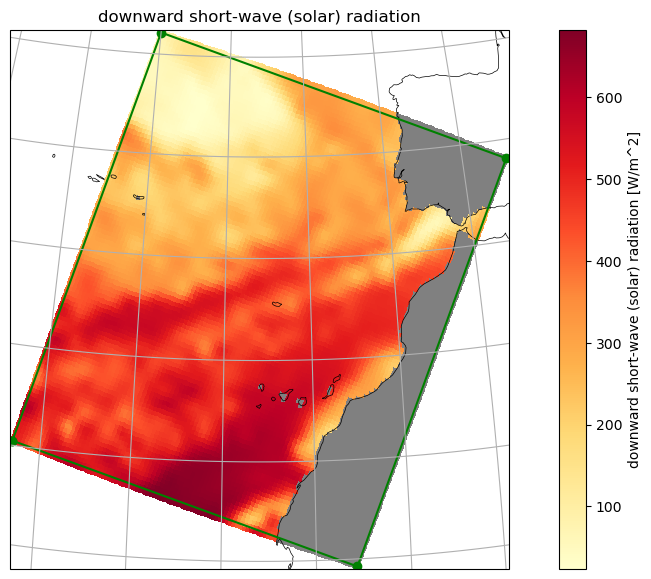

In [11]:
surface_forcing.plot("swrad", time=15)

## Shortwave radiation correction

There is a consensus that global data products such as ERA5 have biases in radiation due to uncertain cloud-radiative feedbacks. `ROMS-Tools` has the ability to correct for these biases. If `correct_radiation = True`, a multiplicative correction factor is applied to the ERA5 shortwave radiation. The correction factors have been pre-computed based on how much the ERA5 climatology differs from the COREv2 climatology.

In [12]:
%%time
corrected_surface_forcing = SurfaceForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    physics_source={"name": "ERA5", "path": path},
    correct_radiation=True,
    use_coarse_grid=False,
)

CPU times: user 2.14 s, sys: 95.7 ms, total: 2.23 s
Wall time: 2.3 s


The correction factors cover the entire globe and are aligned with the ERA5 latitudes and longitudes. There are 12 time entries, corresponding to each month. You can either create your own (regional or global) dataset with multiplicative correction factors or use the one that we downloaded three cells above. The correction dataset is used by the `SWRCorrection` class.

In [13]:
corrected_surface_forcing.ds["physics"]

DataTree('physics', parent="root")
    Dimensions:   (time: 504, eta_rho: 102, xi_rho: 102)
    Coordinates:
        abs_time  (time) datetime64[ns] 4kB 2012-01-15 ... 2012-02-04T23:00:00
      * time      (time) float64 4kB 4.397e+03 4.397e+03 ... 4.418e+03 4.418e+03
    Dimensions without coordinates: eta_rho, xi_rho
    Data variables:
        uwnd      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
        vwnd      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
        swrad     (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
        lwrad     (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
        Tair      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
        qair      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
        rain      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    Attributes:
        title:                 ROMS surface forcing file created by ROMS-Tools
        roms_tools_version:    0.1.dev73+dirty
        start_time:            2012-01-15 00:00:00
        end_time:              2012-02-05 00:00:00
        physics_source:        ERA5
        correct_radiation:     True
        use_coarse_grid:       False
        model_reference_date:  2000-01-01 00:00:00

Here is a plot of the downward short-wave radiation, as before, but now in its corrected version.

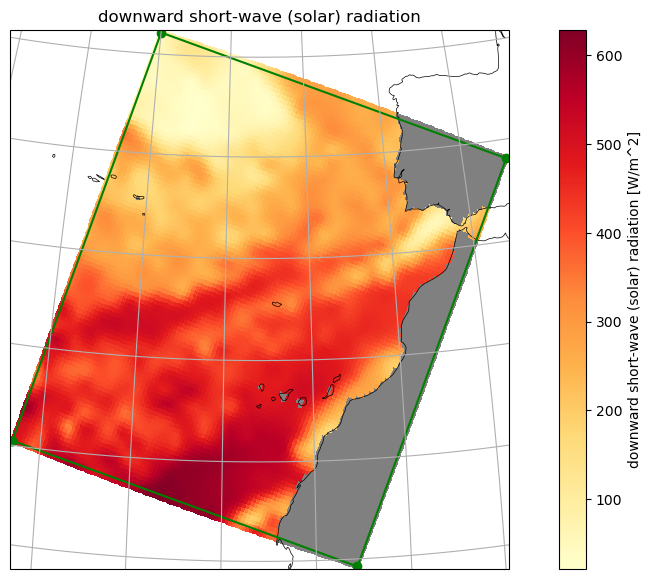

In [14]:
corrected_surface_forcing.plot("swrad", time=15)

To visualize the difference between the corrected and uncorrected short-wave radiation, you can use `xarray`'s plotting method. 

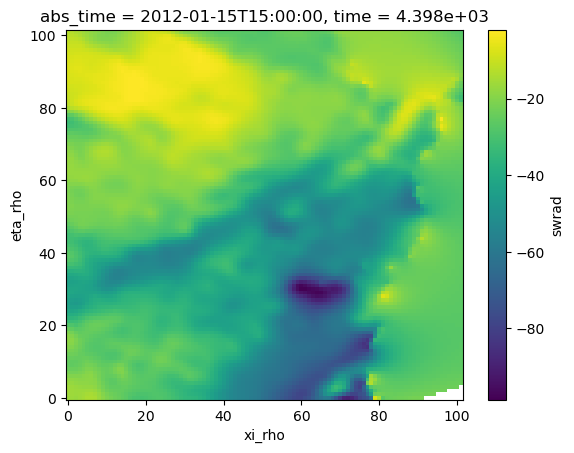

In [15]:
(corrected_surface_forcing.ds["physics"] - surface_forcing.ds["physics"]).swrad.isel(
    time=15
).plot()

## Creating surface forcing on a coarsened grid
`ROMS-Tools` has the option to interpolate the surface forcing fields on a grid that is coarsened by a factor of 2. Interpolating to a coarse grid makes sense when the ROMS grid is of much higher resolution than the raw data product (e.g., ERA5).

In [16]:
%%time
coarse_surface_forcing = SurfaceForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    physics_source={"name": "ERA5", "path": path},
    correct_radiation=True,
    use_coarse_grid=True,
)

CPU times: user 1.83 s, sys: 64.4 ms, total: 1.89 s
Wall time: 1.94 s


In [17]:
coarse_surface_forcing.ds["physics"]

DataTree('physics', parent="root")
    Dimensions:   (time: 504, eta_rho: 52, xi_rho: 52)
    Coordinates:
        abs_time  (time) datetime64[ns] 4kB 2012-01-15 ... 2012-02-04T23:00:00
      * time      (time) float64 4kB 4.397e+03 4.397e+03 ... 4.418e+03 4.418e+03
    Dimensions without coordinates: eta_rho, xi_rho
    Data variables:
        uwnd      (time, eta_rho, xi_rho) float32 5MB dask.array<chunksize=(1, 52, 52), meta=np.ndarray>
        vwnd      (time, eta_rho, xi_rho) float32 5MB dask.array<chunksize=(1, 52, 52), meta=np.ndarray>
        swrad     (time, eta_rho, xi_rho) float32 5MB dask.array<chunksize=(1, 52, 52), meta=np.ndarray>
        lwrad     (time, eta_rho, xi_rho) float32 5MB dask.array<chunksize=(1, 52, 52), meta=np.ndarray>
        Tair      (time, eta_rho, xi_rho) float32 5MB dask.array<chunksize=(1, 52, 52), meta=np.ndarray>
        qair      (time, eta_rho, xi_rho) float32 5MB dask.array<chunksize=(1, 52, 52), meta=np.ndarray>
        rain      (time, eta_rho, xi_rho) float32 5MB dask.array<chunksize=(1, 52, 52), meta=np.ndarray>
    Attributes:
        title:                 ROMS surface forcing file created by ROMS-Tools
        roms_tools_version:    0.1.dev73+dirty
        start_time:            2012-01-15 00:00:00
        end_time:              2012-02-05 00:00:00
        physics_source:        ERA5
        correct_radiation:     True
        use_coarse_grid:       True
        model_reference_date:  2000-01-01 00:00:00

The surface forcing fields now live on the coarsened grid. 

<div class="alert alert-info">

Note

The dimension names in `coarse_forcing.ds` are somewhat confusingly called `eta_rho`, `xi_rho` (rather than `eta_coarse`, `xi_coarse`). This is due to a particularity of ROMS - it expects the dimension names `eta_rho`, `xi_rho`. We should change this in the future! 

</div>

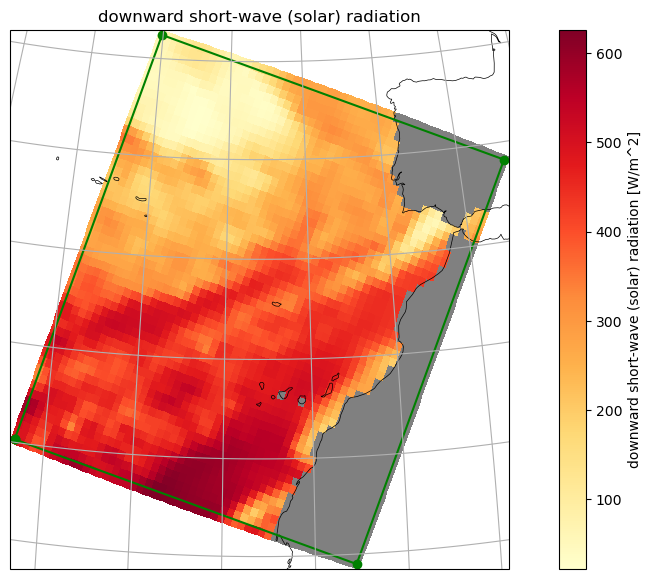

In [18]:
coarse_surface_forcing.plot("swrad", time=15)

## Adding BGC surface forcing
We now create surface forcing that include both physical variables (again from GLORYS) and biogeochemical (BGC) variables. The BGC variables are taken from a CESM climatology, which is located here.

In [19]:
bgc_path = "/glade/derecho/scratch/noraloose/roms-tools-data/BGC/CESM-surface_lowres_regridded.nc"

In [20]:
%%time

surface_forcing_with_bgc = SurfaceForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    physics_source={"name": "ERA5", "path": path},
    bgc_source={"name": "CESM_REGRIDDED", "path": bgc_path},
    use_coarse_grid=False,
    correct_radiation=True,
)

CPU times: user 2.22 s, sys: 125 ms, total: 2.34 s
Wall time: 2.59 s


The DataTree accessible via the `.ds` property now has two groups -- `physics` and `bgc` -- with the corresponding boundary forcing variables.

In [21]:
surface_forcing_with_bgc.ds["physics"]

DataTree('physics', parent="root")
    Dimensions:   (time: 504, eta_rho: 102, xi_rho: 102)
    Coordinates:
        abs_time  (time) datetime64[ns] 4kB 2012-01-15 ... 2012-02-04T23:00:00
      * time      (time) float64 4kB 4.397e+03 4.397e+03 ... 4.418e+03 4.418e+03
    Dimensions without coordinates: eta_rho, xi_rho
    Data variables:
        uwnd      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
        vwnd      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
        swrad     (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
        lwrad     (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
        Tair      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
        qair      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
        rain      (time, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    Attributes:
        title:                 ROMS surface forcing file created by ROMS-Tools
        roms_tools_version:    0.1.dev73+dirty
        start_time:            2012-01-15 00:00:00
        end_time:              2012-02-05 00:00:00
        physics_source:        ERA5
        bgc_source:            CESM_REGRIDDED
        correct_radiation:     True
        use_coarse_grid:       False
        model_reference_date:  2000-01-01 00:00:00

In [22]:
surface_forcing_with_bgc.ds["bgc"]

DataTree('bgc', parent="root")
    Dimensions:       (time: 1, eta_rho: 102, xi_rho: 102)
    Coordinates:
        abs_time      (time) datetime64[ns] 8B 2012-02-01
      * time          (time) float64 8B 4.414e+03
    Dimensions without coordinates: eta_rho, xi_rho
    Data variables:
        pco2_air      (time, eta_rho, xi_rho) float32 42kB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
        pco2_air_alt  (time, eta_rho, xi_rho) float32 42kB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
        iron          (time, eta_rho, xi_rho) float32 42kB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
        dust          (time, eta_rho, xi_rho) float32 42kB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
        nox           (time, eta_rho, xi_rho) float32 42kB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
        nhy           (time, eta_rho, xi_rho) float32 42kB dask.array<chunksize=(1, 102, 102), meta=np.ndarray>
    Attributes:
        title:                 ROMS surface forcing file created by ROMS-Tools
        roms_tools_version:    0.1.dev73+dirty
        start_time:            2012-01-15 00:00:00
        end_time:              2012-02-05 00:00:00
        physics_source:        ERA5
        bgc_source:            CESM_REGRIDDED
        correct_radiation:     True
        use_coarse_grid:       False
        model_reference_date:  2000-01-01 00:00:00

Note that the time variables in `surface_forcing_with_bgc.ds["physics"]` and `surface_forcing_with_bgc.ds["bgc"]` differ, as seen in the two following cells.

In [23]:
surface_forcing_with_bgc.ds["physics"].time

<xarray.DataArray 'time' (time: 504)> Size: 4kB
array([4397.      , 4397.041667, 4397.083333, ..., 4417.875   , 4417.916667,
       4417.958333])
Coordinates:
    abs_time  (time) datetime64[ns] 4kB 2012-01-15 ... 2012-02-04T23:00:00
  * time      (time) float64 4kB 4.397e+03 4.397e+03 ... 4.418e+03 4.418e+03
Attributes:
    long_name:  days since 2000-01-01

In [24]:
surface_forcing_with_bgc.ds["bgc"].time

<xarray.DataArray 'time' (time: 1)> Size: 8B
array([4414.])
Coordinates:
    abs_time  (time) datetime64[ns] 8B 2012-02-01
  * time      (time) float64 8B 4.414e+03
Attributes:
    long_name:  days since 2000-01-01

* `surface_forcing_with_bgc.ds["physics"]` has 504 time entries (as seen above) since we asked for times between January 15 and February 5 in 2012 and the provided data in `physics_source={"name": "ERA5", "path": path}` has hourly data.
* `surface_forcing_with_bgc.ds["bgc"]` has only one time entry because the data in `bgc_source={"name": "CESM_REGRIDDED", "path": bgc_path}` has only monthly data.

We can plot both physical and BGC surface forcing as we saw above.

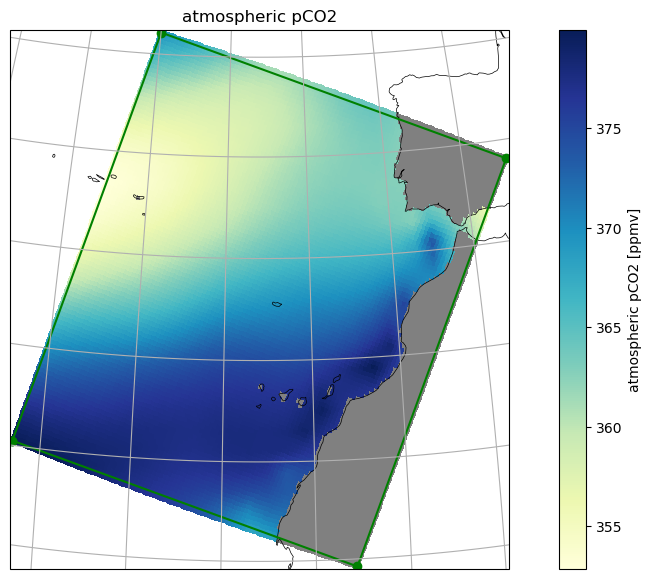

In [25]:
surface_forcing_with_bgc.plot("pco2_air", time=0)

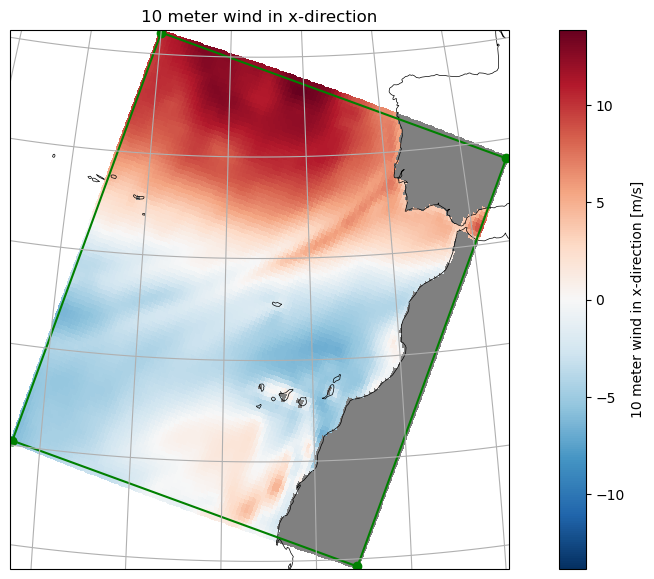

In [26]:
surface_forcing_with_bgc.plot("uwnd", time=0)

## Saving as NetCDF or YAML file
Once we have decided which of the surface forcing versions we actually want to use, we can save the dataset as a series of NetCDF files.

We need to specify a prefix for the desired target path.

In [27]:
filepath = "/glade/derecho/scratch/noraloose/forcing/my_surface_forcing"

`ROMS-Tools` will group the surface forcing by year and month and append the year and month information to this path. The files will be named with the format `filepath.YYYYMM.nc` if a full month of data is included (at least one data point per day), or `filepath.YYYYMMDD-DD.nc` otherwise.

In [28]:
from dask.diagnostics import ProgressBar

In [29]:
with ProgressBar():
    %time surface_forcing_with_bgc.save(filepath)

Saving the following files:
/glade/derecho/scratch/noraloose/forcing/my_surface_forcing_physics_20120115-31.nc
/glade/derecho/scratch/noraloose/forcing/my_surface_forcing_physics_20120201-04.nc
/glade/derecho/scratch/noraloose/forcing/my_surface_forcing_bgc_20120201-01.nc
[########################################] | 100% Completed | 211.20 s
CPU times: user 3min 9s, sys: 6.75 s, total: 3min 16s
Wall time: 3min 34s


We can also export the parameters of our `SurfaceForcing` object to a YAML file.

In [30]:
yaml_filepath = "/glade/derecho/scratch/noraloose/forcing/my_surface_forcing.yaml"

In [31]:
surface_forcing_with_bgc.to_yaml(yaml_filepath)

This is the YAML file that was created.

In [32]:
# Open and read the YAML file
with open(yaml_filepath, "r") as file:
    file_contents = file.read()

# Print the contents
print(file_contents)

---
roms_tools_version: 0.1.dev73+dirty
---
Grid:
  N: 100
  center_lat: 33
  center_lon: -18
  hc: 300.0
  hmin: 5.0
  nx: 100
  ny: 100
  rot: -20
  size_x: 2000
  size_y: 2400
  theta_b: 2.0
  theta_s: 5.0
  topography_source: ETOPO5
SurfaceForcing:
  bgc_source:
    climatology: false
    name: CESM_REGRIDDED
    path: /glade/derecho/scratch/noraloose/roms-tools-data/BGC/CESM-surface_lowres_regridded.nc
  correct_radiation: true
  end_time: '2012-02-05T00:00:00'
  model_reference_date: '2000-01-01T00:00:00'
  physics_source:
    climatology: false
    name: ERA5
    path: /glade/derecho/scratch/bachman/ERA5/NA/ERA5*
  start_time: '2012-01-15T00:00:00'
  use_coarse_grid: false



## Creating surface forcing from an existing YAML file

In [33]:
%time the_same_surface_forcing_with_bgc = SurfaceForcing.from_yaml(yaml_filepath)

CPU times: user 5.89 s, sys: 863 ms, total: 6.76 s
Wall time: 7.48 s


## Spinning up a customized dask cluster [UNDER CONSTRUCTION]

The above calculation utilized Dask's **single-machine**, thread-based default **scheduler**. If this option works well for your needs, that's great! However, you might encounter two potential issues:

1. The single-machine scheduler may not scale efficiently for large computations, such as processing multiple years of forcing data on a high-resolution ROMS grid.
2. Your Jupyter notebook kernel may crash due to running out of memory.

Both issues can be addressed by using Dask's **distributed scheduler**. The distributed scheduler can be run locally or distributed across a cluster. An overview of Dask schedulers can be found [here](https://docs.dask.org/en/stable/scheduling.html).

The following gives an example for how to run a Dask distributed scheduler locally.

In [34]:
from dask.distributed import LocalCluster

In [ ]:
cluster = LocalCluster()
client = cluster.get_client()
client

Since this jupyter notebook runs on a single core on casper, Dask has automatically chosen only a single worker and a single thread. Note that the cluster now operates process-based.

Let's repeat our calculation, but this time with the local Dask cluster.

In [46]:
%%time
yet_the_same_surface_forcing_with_bgc = SurfaceForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    physics_source={"name": "ERA5", "path": path},
    bgc_source={"name": "CESM_REGRIDDED", "path": bgc_path},
    use_coarse_grid=False,
    correct_radiation=True,
)

CPU times: user 2.45 s, sys: 93.2 ms, total: 2.54 s
Wall time: 16 s


In [47]:
filepath = "/glade/derecho/scratch/noraloose/forcing/my_duplicated_surface_forcing"

In [48]:
%time yet_the_same_surface_forcing_with_bgc.save(filepath)

Saving the following files:
/glade/derecho/scratch/noraloose/forcing/my_duplicated_surface_forcing_physics_20120115-31.nc
/glade/derecho/scratch/noraloose/forcing/my_duplicated_surface_forcing_physics_20120201-04.nc
/glade/derecho/scratch/noraloose/forcing/my_duplicated_surface_forcing_bgc_20120201-01.nc
CPU times: user 37 s, sys: 2.35 s, total: 39.4 s
Wall time: 5min 45s


<div class="alert alert-info">

Note

If we had run this notebook on a CPU node on Perlmutter, the same `LocalCluster()` command would create a cluster with 16 workers, totaling 256 threads and 476.56 GiB of memory. 

Note that on Perlmutter the default single-machine, thread-based default scheduler (the one above this section) does not work.
</div>